In [46]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import h5py
from skimage import io
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")
import pandas as pd

In [15]:
def mat2rate(VV, tspan, time_constant=200.):
    from scipy.signal import convolve
    # Single-exponential kernel with mimicking Ca++ kernel
    rate_filter = np.exp(-tspan/time_constant)/np.exp(-tspan/time_constant).sum()
    VV = np.matrix(VV).astype(int)
    rate = []
    for nNeuron in VV:
        spk = np.asarray(nNeuron).squeeze()
        rate.append(convolve(spk, rate_filter, 'full')[1:spk.shape[0]+1])
    return np.matrix(rate)

In [16]:
def gaussian(y, window_size=3, sigma=2):
    from scipy import signal
    filt = signal.gaussian(window_size, sigma)
    filt = filt/filt.sum()
    return signal.convolve(y, filt, mode='same')

In [17]:
def mat2rate_gauss(VV, window_size, sigma):
    VV = np.matrix(VV).astype(int)
    rate = []
    for nNeuron in VV:
        spk = np.asarray(nNeuron).squeeze()
        rate.append(gaussian(spk, window_size, sigma))
    return np.matrix(rate)

In [18]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n
    return ret / n

In [19]:
def mat2rate_boxcar(VV):
    VV = np.matrix(VV).astype(int)
    rate = []
    for nNeuron in VV:
        spk = np.asarray(nNeuron).squeeze()
        rate.append(moving_average(spk, n=600))
    return np.matrix(rate)

In [2]:
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/'
dat_xls_file = pd.read_csv(dat_folder + 'Voltron Log_DRN_Exp.csv', index_col=0)
if 'index' in dat_xls_file.columns:
    dat_xls_file = dat_xls_file.drop('index', axis=1)
dat_xls_file['folder'] = dat_xls_file['folder'].astype(int).apply(str)

# Spike detection

In [113]:
row = dat_xls_file.iloc[-1]
folder = row['folder']
fish = row['fish']
swim_folder = dat_folder + f'{folder}/{fish}/swim/'
rawdata = np.load(swim_folder + 'rawdata.npy')[()]
swimdata = np.load(swim_folder + 'swimdata.npy')[()]
frame= (rawdata['ch3']>2).astype('int')
frame_= (frame[1:] - frame[:-1])<0
frame[:-1] = frame_ > 0
task1 = rawdata["stimParam3"][frame.astype('bool')][600:].astype('uint')
task2 = rawdata["stimParam4"][frame.astype('bool')][600:].astype('uint')
task3 = rawdata["stimParam5"][frame.astype('bool')][600:].astype('uint')

In [106]:
summary_folder = dat_folder + 'Session_summary'

time_tag = task1.shape[0]
spk_list = []

for index, row in dat_xls_file.iterrows():
    if index != 32:
        continue
    folder = row['folder']
    fish = row['fish']
    save_folder = dat_folder + f'{folder}/{fish}/Data'
    _ = np.load(f'{save_folder}/Voltr_spikes.npz')
    spk_list.append(_['spk1'][:, :time_tag])

spk_list = np.concatenate(spk_list, axis=0)
tspan = np.arange(time_tag)/300.
rate_ = mat2rate_boxcar(spk_list)

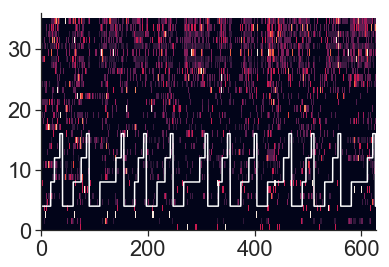

In [107]:
# plt.figure(figsize=(20, 4))
# plt.plot(tspan, np.array(rate_)[:, :].mean(axis=0)*300)
rate_mat = np.array(rate_)
rate_mat = rate_mat/rate_mat.max(axis=-1, keepdims=True)
ind = np.argsort(rate_mat.mean(axis=-1))
plt.imshow(rate_mat[ind, :], aspect='auto', origin='lower', extent=[0, tspan[-1], 0, rate_.shape[0]+1])
plt.plot(tspan, task1*4, '-w')
# plt.xlim([0, tspan[-1]])
sns.despine()
# plt.savefig(f'{summary_folder}/Spike_Subvolt/0{folder}_{fish}_ave_rate.svg')

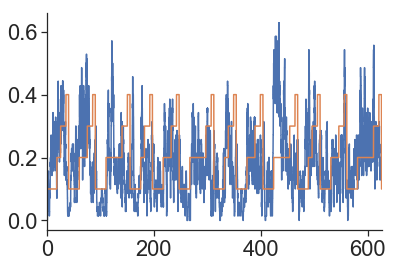

In [108]:
rate_mat = np.array(rate_)
plt.plot(tspan, rate_mat.mean(axis=0)*300)
plt.plot(tspan, task1/10)
plt.xlim([0, tspan[-1]])
sns.despine()
# plt.savefig(f'{summary_folder}/Spike_Subvolt/0{folder}_{fish}_ave_rate.svg')

In [109]:
summary_folder = dat_folder + 'Session_summary'

time_tag = task1.shape[0]
spk_list = []

for index, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    save_folder = dat_folder + f'{folder}/{fish}/Data'
    _ = np.load(f'{save_folder}/Voltr_spikes.npz')
    spk_list.append(_['spk1'][:, :time_tag])

spk_list = np.concatenate(spk_list, axis=0)
tspan = np.arange(time_tag)/300.
rate_ = mat2rate_boxcar(spk_list)

In [124]:
data_list = []
for ntask3 in range(task3.max()):
    x = task3 == ntask3+1
    for ntask2 in range(task2.max()):
        y = task2 == ntask2+1
        for ntask1 in range(task1.max()):
            z = task1 == ntask1+1
            ind = np.logical_and.reduce((x, y, z))
            data_list.append(rate_[:, ind].mean(axis=-1)*300)

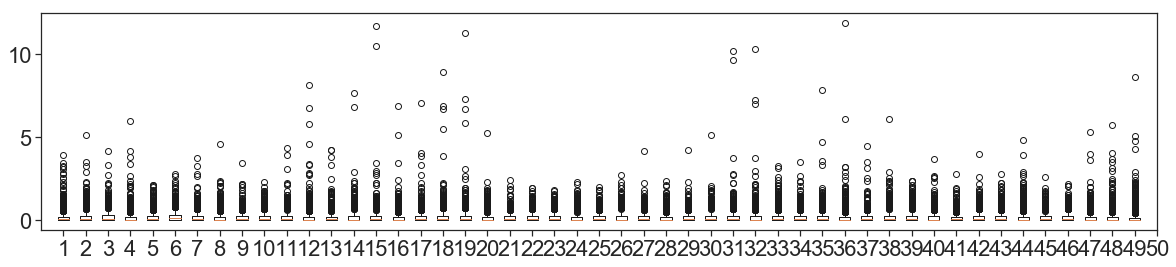

In [132]:
plt.figure(figsize=(20, 4))
plt.boxplot(np.array(data_list).squeeze(axis=-1).T)
plt.xlim([0, 50])
plt.show()

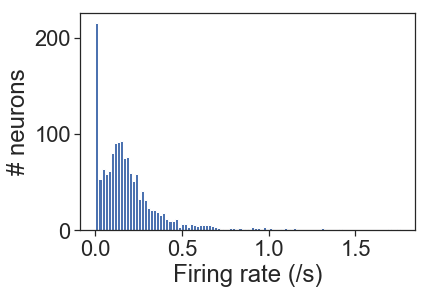

In [161]:
plt.hist(rate_.mean(axis=-1)*300, bins=100)
plt.xlabel('Firing rate (/s)')
plt.ylabel('# neurons')
plt.show()

In [180]:
dat_task = np.array(data_list).squeeze(axis=-1)[:48,:]
dat_task = dat_task[:, dat_task.mean(axis=0)>0.2]

In [181]:
dat_task.shape

(48, 496)

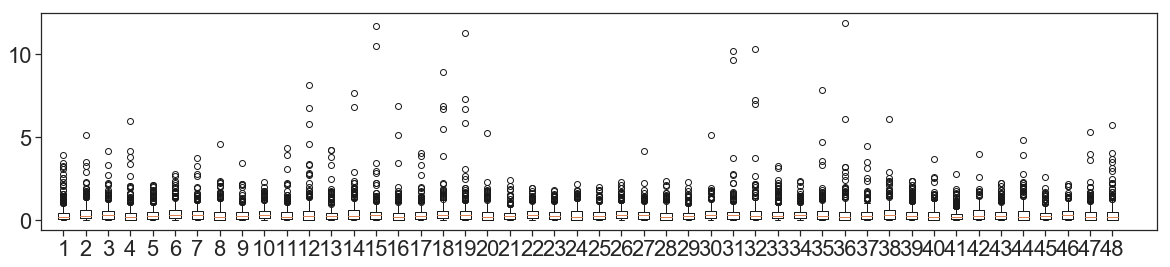

In [175]:
plt.figure(figsize=(20, 4))
plt.boxplot(dat_task.T)
plt.xlim([0, 50])
plt.show()

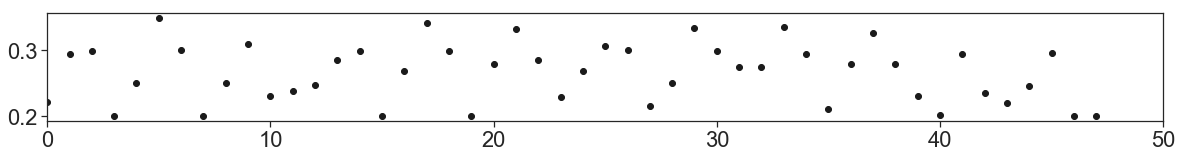

In [176]:
plt.figure(figsize=(20, 2))
plt.plot(np.median(dat_task, axis=-1), 'ok')
plt.xlim([0, 50])
plt.show()

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pcs = pca.fit(rate_mat.T).fit_transform(rate_mat.T)

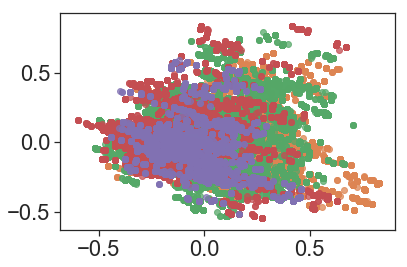

In [81]:
for n in range(5):
    plt.scatter(pcs[task1==n, 1], pcs[task1==n, 2], alpha=0.75)

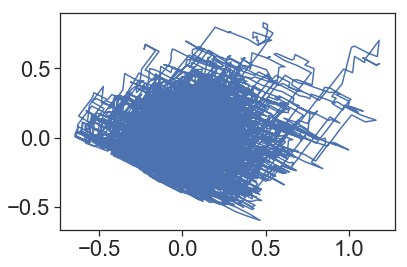

In [84]:
plt.plot(pcs[:, 0], pcs[:, 1])

In [ ]:
pca.fit(spk_rate.T)
plt.plot(pca.explained_variance_)

# Subthreshold

In [ ]:
# summary_folder = dat_folder + 'Session_summary'

# for index, row in dat_xls_file.iterrows():
#     folder = row['folder']
#     fish = row['fish']
#     save_folder = dat_folder + f'{folder}/{fish}/Data'
#     _ = np.load(f'{save_folder}/Voltr_spikes.npz')
#     voltr_ = _['voltr_']
#     _ = np.load(f'{save_folder}/Voltr_subvolt.npz')
#     subvolt_ = _['norm_subvolt']
#     n_, len_ = voltr_.shape
#     swim_folder = dat_folder + f'{folder}/{fish}/swim/'
#     rawdata = np.load(swim_folder + 'rawdata.npy')[()]
#     swimdata = np.load(swim_folder + 'swimdata.npy')[()]
#     frame= (rawdata['ch3']>2).astype('int')
#     frame_= (frame[1:] - frame[:-1])<0
#     frame[:-1] = frame_ > 0
#     swim_left = swimdata['fltCh1'][frame.astype('bool')][600:]
#     swim_right = swimdata['fltCh2'][frame.astype('bool')][600:]
#     task = rawdata["stimParam3"][frame.astype('bool')][600:]
#     task = task - task.min()
    
    
#     plt.figure(figsize=(20, (n_+6)/20*20))
#     for m_ in range(n_):
#         volt = voltr_[m_, :]
#         subvolt = subvolt_[m_, :]
#         volt_min = volt.min()
#         volt_max = volt.max()
#         volt = (volt-volt_min)/(volt_max-volt_min)
#         subvolt = (subvolt-volt_min)/(volt_max-volt_min)
#         plt.plot(volt + m_, '-', color='orange')
#         plt.plot(subvolt + m_, '-k')

#     plt.plot((swim_left/swim_left.max() * 3)-3)
#     plt.plot((swim_right/swim_right.max() * 3)-6)
#     plt.plot(task/task.max()*n_, lw=2)
#     plt.xlim([0, len_])
#     plt.savefig(f'{summary_folder}/Subvolt/0{folder}_{fish}.svg')

In [ ]:
summary_folder = dat_folder + 'Session_summary'

time_tag = 188100
spk_list = []

for index, row in dat_xls_file.iterrows():
    if index > 
    folder = row['folder']
    fish = row['fish']
    save_folder = dat_folder + f'{folder}/{fish}/Data'
    _ = np.load(f'{save_folder}/Voltr_spikes.npz')
    spk_list.append(_['spk1'][:, :time_tag])    

# Combined

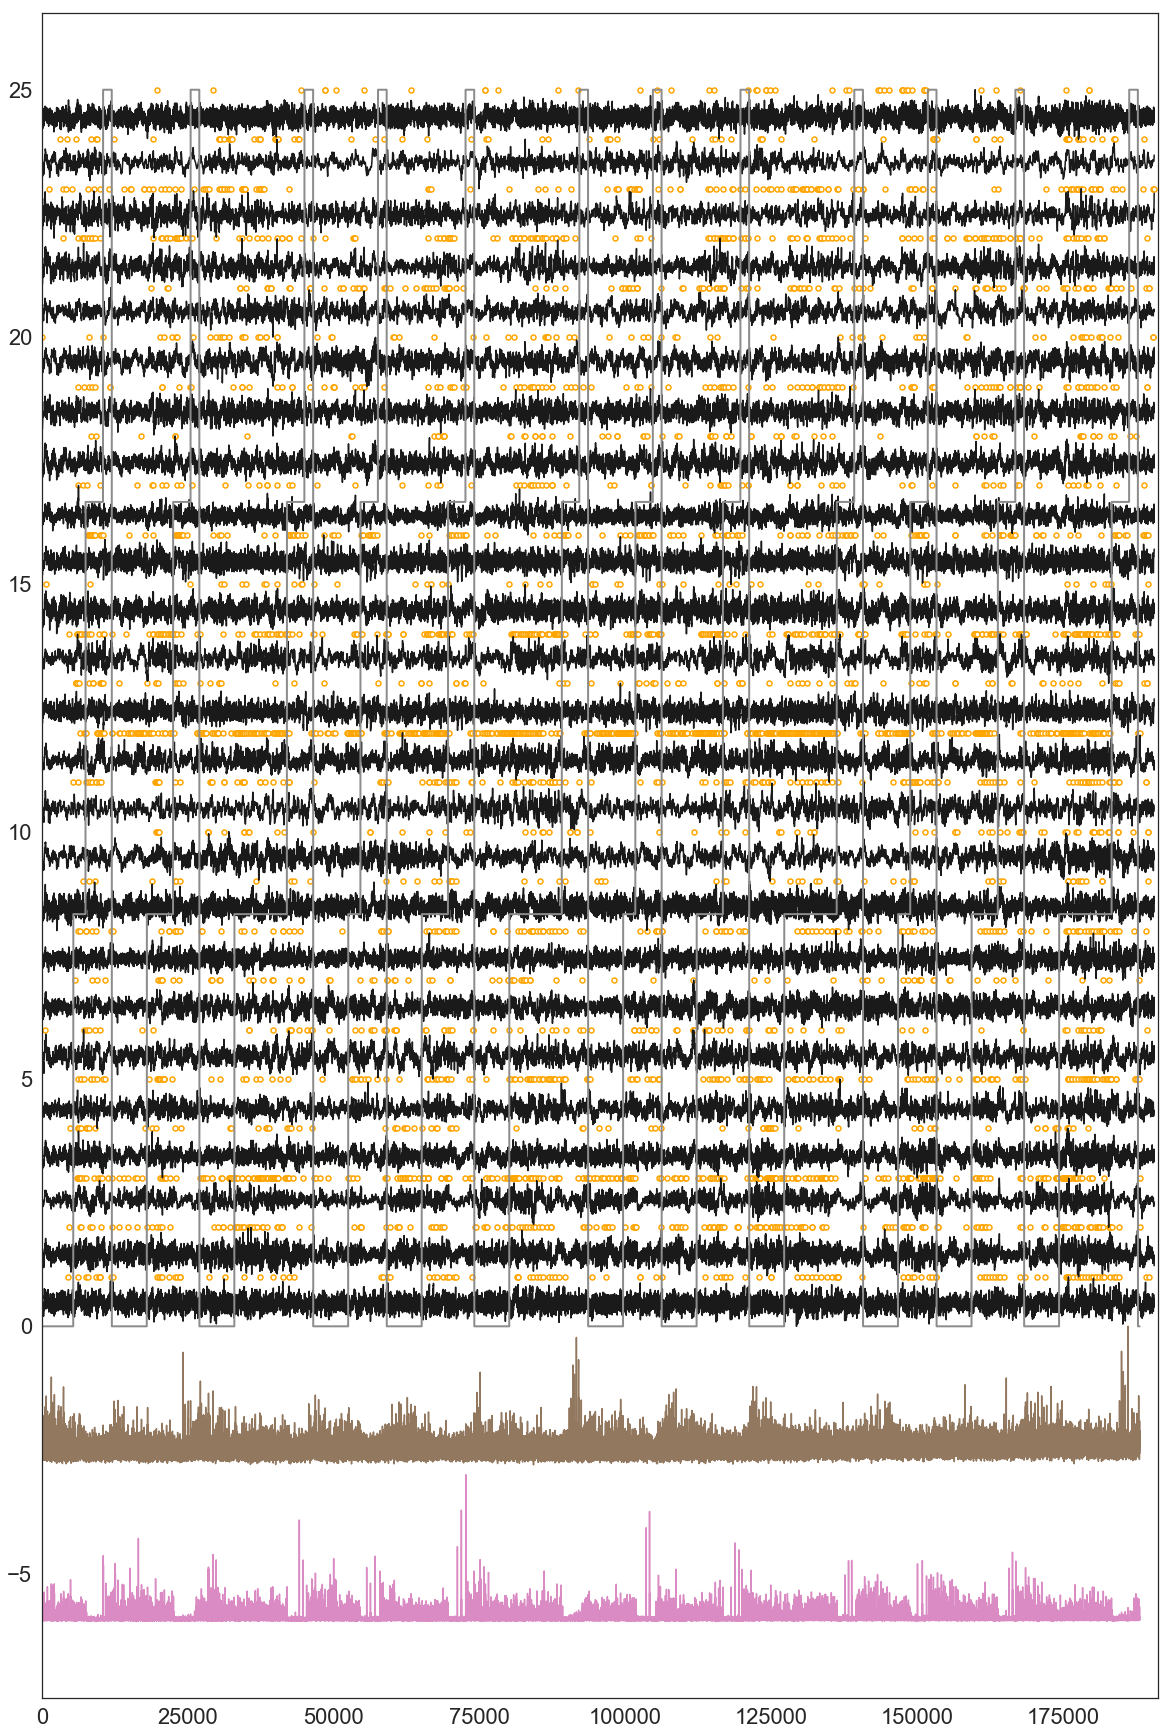

In [30]:
summary_folder = dat_folder + 'Session_summary'

for index, row in dat_xls_file.iterrows():
    if index>=1:
        continue
    folder = row['folder']
    fish = row['fish']
    save_folder = dat_folder + f'{folder}/{fish}/Data'
    _ = np.load(f'{save_folder}/Voltr_spikes.npz')
    voltrs = _['voltrs']
    spk = _['spk']
    spkprob = _['spkprob']
    spk1 = _['spk1']
    spk2 = _['spk2']
    voltr_ = _['voltr_']
    n_, len_ = voltrs.shape
    _ = np.load(f'{save_folder}/Voltr_subvolt.npz')
    subvolt_ = _['norm_subvolt']
    swim_folder = dat_folder + f'{folder}/{fish}/swim/'
    rawdata = np.load(swim_folder + 'rawdata.npy')[()]
    swimdata = np.load(swim_folder + 'swimdata.npy')[()]
    frame= (rawdata['ch3']>2).astype('int')
    frame_= (frame[1:] - frame[:-1])<0
    frame[:-1] = frame_ > 0
    swim_left = swimdata['fltCh1'][frame.astype('bool')][600:]
    swim_right = swimdata['fltCh2'][frame.astype('bool')][600:]
    task = rawdata["stimParam3"][frame.astype('bool')][600:]
    task = task - task.min()
    
    
    plt.figure(figsize=(20, (n_+6)/20*20))
    for m_, n_spk in enumerate(spk1):
        spk_ = np.where(n_spk)[0]
        plt.plot(spk_, np.ones(len(spk_))*m_+1, 'o', markersize=5, markerfacecolor='w',markeredgewidth=1.5, markeredgecolor='orange')
        volt = voltr_[m_, :]
        subvolt = subvolt_[m_, :]
        volt_min = subvolt.min()
        volt_max = subvolt.max()
#         volt = (volt-volt_min)/(volt_max-volt_min)
        subvolt = (subvolt-volt_min)/(volt_max-volt_min)
#         plt.plot(volt + m_, '-', color='orange')
        plt.plot(subvolt + m_, '-k')

    plt.plot((swim_left/swim_left.max() * 3)-3)
    plt.plot((swim_right/swim_right.max() * 3)-6)
    plt.plot(task/task.max()*n_, lw=2)
    plt.xlim([0, len_])
    plt.savefig(f'{summary_folder}/Spike_Subvolt/0{folder}_{fish}.svg')

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(tspan, np.array(subvolt_)[:25, :time_tag].mean(axis=0))
plt.plot(tspan, task/10)
plt.xlim([0, tspan[-1]])
plt.savefig(f'{summary_folder}/Spike_Subvolt/0{folder}_{fish}_ave_subvolt.svg')

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch

d = sch.distance.pdist(subvolt_, 'correlation')
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.1*d.max(), 'distance')
corr_ = np.corrcoef(subvolt_[ind, :])
plt.imshow(corr_, cmap='gray', vmin=0)
plt.colorbar()